<a href="https://colab.research.google.com/github/DavidMoralesMejia/Robo_Trading/blob/main/robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Preparación del entorno de trabajo**
En este apartado prepararemos lo necesario para poder hacer uso de las múltiples funcionalidades con las que cuenta Google Colab.

Esto implica instalación/importación de librerias y definición de variables a usar.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf     # Importamos la librería de 'Yahoo Finance' para analizar, mostrar los datos
import mplfinance as mpl  # Importa la librería 'mplfinance' con el subfijo 'mpl'
from bs4 import BeautifulSoup
import requests
import datetime
#import pytz
#import re

In [4]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision     # Definimos variables globales a utilizar

# **2.Obtención de datos**
En la siguiente funcióndefinimos la variable global que contendrá el dataframe de la inforamción con la que trabajaremos en este proyecto.

La información es extraida de la librería **yfinance** la cual nos permite obtener la información del precio de diferentes monedas y divisas de la bolsa de mercado.



In [25]:
def importar_base():
  global df_bitcoin
  df_bitcoin=yf.Ticker('BTC-USD').history(period='7d', interval='5m')

Para el siguiente paso es fue necesario realizar una extracción de la tendencia de una fuente externa, como lo fue: https://coinmarketcap.com/ donde fue necesario hacer uso de un método conocido como "*Web Scraping*".

**Nota:** *Para esta parte se ha solicitado extraer la tendencia de la moneda Bitcoin, y a su vez informar si se encontraba a la baja o a la alza.*

In [99]:
url='https://coinmarketcap.com/'
req=requests.get(url)
soup = BeautifulSoup(req.text, 'html')
dic={}
prueba=[]

def extraer_tendencia():
  global name, cierre, valor, alza_baja, tendencia, direccion, precio_actual

  for row in soup.findAll('tr')[1:5]:
    name=row.findAll('td')[2].text
    valor=row.findAll('td')[3]
    alza_baja=row.findAll('td')[4].text
    inner=row.findAll('td')[4].span.span['class']

    cierre=float(valor.text.replace(',','').replace('$',''))
    prueba.append(inner)
    prueba.append(alza_baja)
    prueba.append(cierre)

    dic[name]=prueba

  direccion=dic['BitcoinBTC'][0]

  if direccion == 'icon-Caret-up':
    tendencia='alza'
  else:
    tendencia='baja'

  precio_actual=dic['BitcoinBTC'][2]

# **3. Limpieza de Datos**
Para la limpieza de datos fue necesario realizar una eliminación de datos nulos y de datos con volumen con valor a 0, ya que, generarián ruido a la hora de trabajar con los datos por la cantidad de los mismos.

**Nota:** *Para identificar si se tenian valores con **'volume de 0'** fue necesario hacer uso del siguiente codigo*:  **datos.query('Volume<=0')**

In [7]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpios, tendencia, media_bitcoin, q1, q3

    df_bitcoin_limpios=df_bitcoin.copy()
    df_bitcoin_limpios.drop_duplicates(inplace=True)

    query_volume=df_bitcoin_limpios.query('Volume <=0').index

    df_bitcoin_limpios.drop(query_volume, axis=0, inplace=True)

    print(type(df_bitcoin_limpios))

    q1=df_bitcoin_limpios['Close'].quantile(0.25)
    q3=df_bitcoin_limpios['Close'].quantile(0.75)

    query_quantiles=(f'Close>{q1} & Close<{q3}')
    df_bitcoin_limpios=df_bitcoin_limpios.query(query_quantiles)

    media_bitcoin=round(df_bitcoin_limpios['Close'].mean(),2)

    # Se realiza un gráfico Boxplot para validar la información que se desea obtener
    #df_bitcoin_limpios.boxplot('Close', notch=True, showmeans=True, meanline=True)

# **4. Toma de decisiones**
Se deifnio un algoritmo sencillo que nos regresaría una "*decisión*" con base a la validación de datos anteriores, esto para definir si las acciones a tomar deben de ser "*Comprar*", "*Vender*" o "*Esperar*"

In [97]:
def tomar_decisiones():
  global algoritmo_decision

  if (precio_actual >= media_bitcoin) and (tendencia=='baja'):
    algoritmo_decision='Vender'
    print(f'El precio actual del Bitcoin, es de: {"${:,.2f}".format(precio_actual)}')
    print(f'El precio del valor promedio del Bitcoin es de: {"${:,.2f}".format(media_bitcoin)}')
    print(f'El porcentaje de cambio es de: \u25be{dic["BitcoinBTC"][1]}, siendo a la {tendencia}')
    print(f'La desición deberá de ser: {algoritmo_decision}')

  elif (precio_actual < media_bitcoin) and (tendencia=='alza'):
    algoritmo_decision='Comprar'
    print(f'El precio actual del Bitcoin, es de: {"${:,.2f}".format(precio_actual)}')
    print(f'El precio del valor promedio del Bitcoin es de: {"${:,.2f}".format(media_bitcoin)}')
    print(f'El porcentaje de cambio es de: \u25b4{dic["BitcoinBTC"][1]}, siendo a la {tendencia}')
    print(f'La desición deberá de ser: {algoritmo_decision}')

  else:
    algoritmo_decision='Esperar'

# **5. Visualización**
Pasando al lado estetico, se creo y personalizo un gráfico de líneas donde se pudiera visualizar la desición, así como una flecha indicativa:
* Rojo=Vender
* Verde= Comprar
* Negro=Esperar

A su vez se mostro la línea del promedio del valor del bitcoin.

In [91]:
def visualizacion():

  plt.figure(figsize=(15, 6))
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio')

  if algoritmo_decision=='Vender':
    face_color='red'
  elif algoritmo_decision=='Comprar':
    face_color='green'
  else:
    face_color='black'

  plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin['Close'][-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'][-1] + 50),
              arrowprops=dict(facecolor=face_color, shrink=0.1))
  plt.annotate('$ {:,.2f}'.format(round(media_bitcoin, 2)), xy=(df_bitcoin.index[1], df_bitcoin['Close'].mean()), xytext=(df_bitcoin.index[1], df_bitcoin['Close'].mean() + 250), color='red')

  plt.axhline(y=df_bitcoin['Close'].mean(), color='red', linestyle='--', label='Promedio')

  plt.legend()
  plt.show()


# **6. Automatización**
Para el último paso se definio un while que nos permite ciclar definida o indefinidamente una operación, en este caso se llamaba a las funciones planteadas para ejecutarlas cada cierto tiempo, que en este caso fue de cada 60s (1min) y volver a calcular la inforamción.

Posterior también se hace una limpieza de pantalla, para ejecutar la nueva gráfica.

In [10]:
from IPython.display import clear_output
import time

<class 'pandas.core.frame.DataFrame'>
El precio actual del Bitcoin, es de: $70,412.49
El precio del valor promedio del Bitcoin es de: $69,177.65
El porcentaje de cambio es de: ▾0.83%, siendo a la baja
La desición deberá de ser: Vender


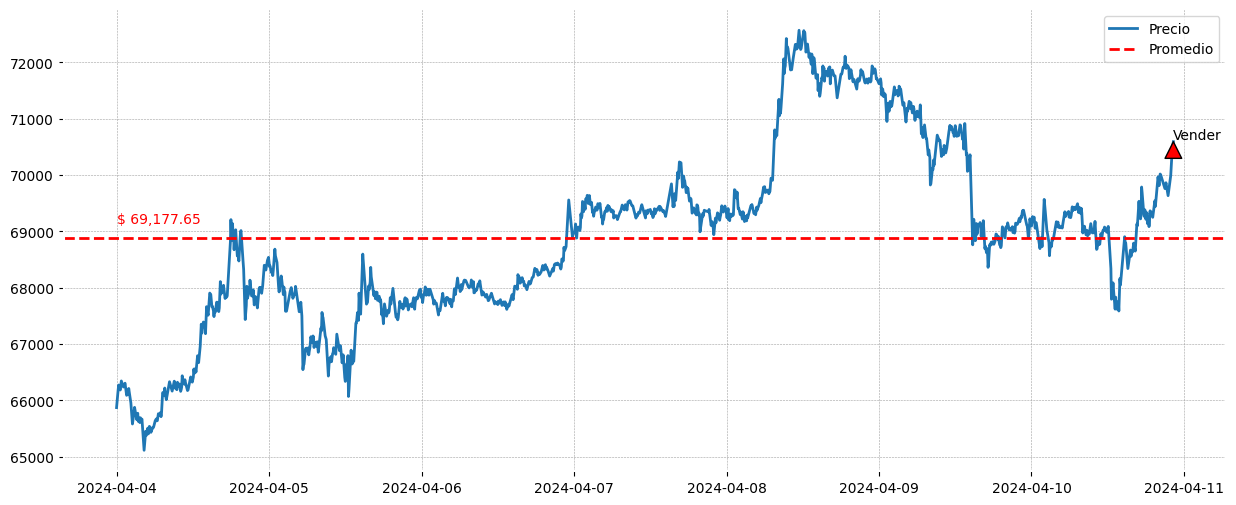

KeyboardInterrupt: 

In [100]:
while(True):
  clear_output()
  importar_base()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(60)

# **Lecciones aprendidas:**
Gracias al conocimiento de los cursos que se han impartido en el Bootcamp de Data Science, fue posible desarrollar este proyecto del Robo-trading, entendiendo y conociendo la gama de posibilidades con las que se puede trabajar con Python en la actualidad, como lo fue:
*   Uso de las variables.
*   Representación gráfica de la información.
*   Extracción de información por medio de web-scraping.

Este proyecto fue enriquecedor gracias a la complejidad que represento el desarrollo de la misma. Así mismo, el uso de diferentes fuentes de inforamción, como el apoyo de los demás estudiantes del bootcamp ha permitido la culminación éxitosa del proyecto.
